# Modeling Protein-Ligand Interactions(SBDD Approach)

The use of machine learning methods to predict the binding energy of a protein-ligand complex. A ligand is some small molecule which interacts (usually non-covalently) with a protein. We'll take the following steps to get there:

1. Loading a chemical dataset, consisting of a series of protein-ligand complexes.
2. Featurizing each protein-ligand complexes with various featurization schemes. 
3. Fitting a series of models with these featurized protein-ligand complexes.
4. Visualizing the results.

I'll use a simple pre-processed dataset file that comes in the form of a pikle file. Each row is a molecular system, and each column represents a different piece of information about that system. For instance, in this example, every row reflects a protein-ligand complex, and the following columns are present: a unique complex identifier; the SMILES string of the ligand; the binding affinity (Ki) of the ligand to the protein in the complex; a Python `list` of all lines in a PDB file for the protein alone; and a Python `list` of all lines in a ligand file for the ligand alone.




In [24]:
import warnings
warnings.filterwarnings("ignore")
import deepchem
deepchem.__version__

'2.3.0'

In [2]:
import deepchem as dc
import pickle
with open("pdbbind_core_5_df.pkl", "rb") as f:
    dataset_file = pickle.load(f)
dataset_file.to_csv('pdbbind_core_df.csv')
raw_dataset = dataset_file

Let's see what `dataset` looks like:

In [3]:
print("Type of dataset is: %s" % str(type(raw_dataset)))
print(raw_dataset[:5])
print("Shape of dataset is: %s" % str(raw_dataset.shape))

Type of dataset is: <class 'pandas.core.frame.DataFrame'>
  pdb_id                                             smiles  \
0   2d3u        CC1CCCCC1S(O)(O)NC1CC(C2CCC(CN)CC2)SC1C(O)O   
1   3cyx  CC(C)(C)NC(O)C1CC2CCCCC2C[NH+]1CC(O)C(CC1CCCCC...   
2   3uo4        OC(O)C1CCC(NC2NCCC(NC3CCCCC3C3CCCCC3)N2)CC1   
3   1p1q                         CC1ONC(O)C1CC([NH3+])C(O)O   
4   3ag9  NC(O)C(CCC[NH2+]C([NH3+])[NH3+])NC(O)C(CCC[NH2...   

                                          complex_id  \
0    2d3uCC1CCCCC1S(O)(O)NC1CC(C2CCC(CN)CC2)SC1C(O)O   
1  3cyxCC(C)(C)NC(O)C1CC2CCCCC2C[NH+]1CC(O)C(CC1C...   
2    3uo4OC(O)C1CCC(NC2NCCC(NC3CCCCC3C3CCCCC3)N2)CC1   
3                     1p1qCC1ONC(O)C1CC([NH3+])C(O)O   
4  3ag9NC(O)C(CCC[NH2+]C([NH3+])[NH3+])NC(O)C(CCC...   

                                         protein_pdb  \
0  [HEADER    2D3U PROTEIN\n, COMPND    2D3U PROT...   
1  [HEADER    3CYX PROTEIN\n, COMPND    3CYX PROT...   
2  [HEADER    3UO4 PROTEIN\n, COMPND    3UO4 PROT...   
3 

Visualizing what these proteins and ligands look like will help us build intuition and understanding about these systems. Let's write a bit of code to help us view our molecules. I'll use the `nglview` library to help us do this. 

In [5]:
import nglview
import tempfile
import os
import mdtraj as md
import numpy as np

I'll use the `mdtraj` library to help us manipulate both ligand and protein objects. I'll use the following convenience function to parse in the ligand and protein representations above into mdtraj.

In [6]:
def convert_lines_to_mdtraj(molecule_lines):
  molecule_lines = molecule_lines.strip('[').strip(']').replace("'","").replace("\\n", "").split(", ")
  tempdir = tempfile.mkdtemp()
  molecule_file = os.path.join(tempdir, "molecule.pdb")
  with open(molecule_file, "w") as f:
    for line in molecule_lines:
        f.write("%s\n" % line)
  molecule_mdtraj = md.load(molecule_file)
  return molecule_mdtraj

Let's take a look at the first protein ligand pair in our dataset:

In [7]:
first_protein, first_ligand = raw_dataset.iloc[0]["protein_pdb"], raw_dataset.iloc[0]["ligand_pdb"]
protein_mdtraj = convert_lines_to_mdtraj(str(first_protein))
ligand_mdtraj = convert_lines_to_mdtraj(str(first_ligand))

I'll use the convenience function `nglview.show_mdtraj` in order to view our proteins and ligands.

In [8]:
v = nglview.show_mdtraj(ligand_mdtraj)

In [9]:
v

NGLWidget()

Now that we have an idea of what the ligand looks like, let's take a look at our protein:

In [10]:
view = nglview.show_mdtraj(protein_mdtraj)
view

NGLWidget()

Can we view the complex with both protein and ligand? Yes, but we'll need the following helper function to join the two mdtraj files for the protein and ligand.

In [11]:
def combine_mdtraj(protein, ligand):
  chain = protein.topology.add_chain()
  residue = protein.topology.add_residue("LIG", chain, resSeq=1)
  for atom in ligand.topology.atoms:
      protein.topology.add_atom(atom.name, atom.element, residue)
  protein.xyz = np.hstack([protein.xyz, ligand.xyz])
  protein.topology.create_standard_bonds()
  return protein
complex_mdtraj = combine_mdtraj(protein_mdtraj, ligand_mdtraj)

Let's now visualize our complex

In [12]:
v = nglview.show_mdtraj(complex_mdtraj)
v

NGLWidget()

We can see that the ligand slots into a groove on the outer edge of the protein. Ok, now that we've got our basic visualization tools up and running, let's see if we can use some machine learning to understand our dataset of protein-ligand systems better.

In order to do this, we'll need a way to transform our protein-ligand complexes into representations which can be used by learning algorithms. Ideally, I'd have neural protein-ligand complex fingerprints, but DeepChem doesn't yet have a good learned fingerprint of this sort. It however have well tuned manual featurizers that can help us with our challenge here.

I'll make of two types of fingerprints for the purpose, the circular fingerprints and the grid descriptors. The grid descriptors convert a 3D volume containing an arragment of atoms into a fingerprint. This is really useful for understanding protein-ligand complexes since it will allow us to transfer protein-ligand complexes into vectors that can be passed into a simple machine learning algorithms. I'll make use of the `dc.feat.RdkitGridFeaturizer` class.

In [13]:
grid_featurizer = dc.feat.RdkitGridFeaturizer(
    voxel_width=16.0, feature_types=["ecfp", "splif", "hbond", "pi_stack", "cation_pi", "salt_bridge"], 
    ecfp_power=5, splif_power=5, parallel=True, flatten=True, sanitize=True)

Next I'll create circular fingerprints. These convert small molecules into a vector of fragments. I will create these fingerprints with the `dc.feat.CircularFingerprint` class.

In [14]:
compound_featurizer = dc.feat.CircularFingerprint(size=128)

The convenience loader `dc.molnet.load_pdbbind_grid` will take care of performing featurizing the pdbbind dataset under the hood for us. I'll use this helper method to perform our featurization for us. I'll featurize the "refined" subset of the PDBBIND dataset (which consists of only a couple thousand protein-ligand complexes) to keep this task manageable.

In [15]:
pdbbind_tasks, (train_dataset, valid_dataset, test_dataset), transformers = dc.molnet.load_pdbbind_grid(
    featurizer="ECFP", subset="refined")

Loading raw samples now.
shard_size: 8192
About to start loading CSV from C:\Users\DEVANS~1\AppData\Local\Temp\refined_smiles_labels.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
TIMING: featurizing shard 0 took 10.122 s
TIMING: dataset construction took 10.658 s
Loading dataset from disk.
TIMING: dataset construction took 0.675 s
Loading dataset from disk.
TIMING: dataset construction took 0.133 s
Loading dataset from disk.
TIMING: dataset construction took 0.146 s
Loading dataset from disk.
TIMING: dataset construction took 0.191 s
Loading dataset from disk.
TIMING: dataset construction took 0.093 s
Loading dataset from disk.
TIMING: dataset construction took 0.116 s
Loading dataset from disk.


Now, we're ready to do some learning! 

To fit a deepchem model, first we instantiate one of the provided (or user-written) model classes. In this case, I have a created a convenience class to wrap around any ML model available in Sci-Kit Learn that can in turn be used to interoperate with deepchem. To instantiate an ```SklearnModel```, you will need (a) task_types, (b) model_params, another ```dict``` as illustrated below, and (c) a ```model_instance``` defining the type of model you would like to fit, in this case a ```RandomForestRegressor```.

In [16]:
from sklearn.ensemble import RandomForestRegressor

seed=23 # Set a random seed to get stable results
sklearn_model = RandomForestRegressor(n_estimators=10, max_features='sqrt')
sklearn_model.random_state = seed
model = dc.models.SklearnModel(sklearn_model)
model.fit(train_dataset)

In [17]:
from deepchem.utils.evaluate import Evaluator
import pandas as pd

metric = dc.metrics.Metric(dc.metrics.r2_score)

evaluator = Evaluator(model, train_dataset, transformers)
train_r2score = evaluator.compute_model_performance([metric])
print("RF Train set R^2 %f" % (train_r2score["r2_score"]))

evaluator = Evaluator(model, valid_dataset, transformers)
valid_r2score = evaluator.compute_model_performance([metric])
print("RF Valid set R^2 %f" % (valid_r2score["r2_score"]))

computed_metrics: [0.8392651645293824]
RF Train set R^2 0.839265
computed_metrics: [0.45425405081244885]
RF Valid set R^2 0.454254


This is decent performance on a validation set! It's interesting to note that a trivial prediction from just the ligand can do reasonably on the task of predicting the binding energy.

In [18]:
predictions = model.predict(test_dataset)
print(predictions[:10])

[-0.3779172  -1.53686709 -1.19082002 -0.53639386 -0.47978197  0.02115084
 -0.63990752 -0.13525554 -1.6992278  -1.7047241 ]


# The protein-ligand complex view.

In the previous section, I featurized only the ligand. The signal we observed in R^2 reflects the ability of grid fingerprints and random forests to learn general features that make ligands "drug-like." This time, let's see if we can do something sensible with our protein-ligand fingerprints that make use of our structural information. To start with, we need to re-featurize the dataset but using the "grid" fingerprints this time.

In [19]:
pdbbind_tasks, (train_dataset, valid_dataset, test_dataset), transformers = dc.molnet.load_pdbbind_grid(
    featurizer="grid", subset="refined")

Loading dataset from disk.
TIMING: dataset construction took 0.458 s
Loading dataset from disk.
TIMING: dataset construction took 0.158 s
Loading dataset from disk.
TIMING: dataset construction took 0.153 s
Loading dataset from disk.


Let's now train a simple random forest model on this dataset.

In [20]:
seed=23 # Set a random seed to get stable results
sklearn_model = RandomForestRegressor(n_estimators=10, max_features='sqrt')
sklearn_model.random_state = seed
model = dc.models.SklearnModel(sklearn_model)
model.fit(train_dataset)

Let's see what our accuracies looks like!

In [21]:
metric = dc.metrics.Metric(dc.metrics.r2_score)

evaluator = Evaluator(model, train_dataset, transformers)
train_r2score = evaluator.compute_model_performance([metric])
print("RF Train set R^2 %f" % (train_r2score["r2_score"]))

evaluator = Evaluator(model, valid_dataset, transformers)
valid_r2score = evaluator.compute_model_performance([metric])
print("RF Valid set R^2 %f" % (valid_r2score["r2_score"]))

computed_metrics: [0.8935792679172591]
RF Train set R^2 0.893579
computed_metrics: [0.4884820245846241]
RF Valid set R^2 0.488482


Ok, there's some predictive performance here, but it looks like we have lower accuracy than the ligand-only dataset. What gives? There might be a few things going on. It's possible that for this particular dataset the pure ligand only features are quite predictive. But nonetheless, it's probably still useful to have a protein-ligand model since it's likely to learn different features than the the pure ligand-only model.

# Doing Some Hyperparameter Optimization

Now that we've built a few models, I will do some hyperparameter optimization to see if we can get our numbers to be a little better. We'll use the `dc.hyper` module to do this for us.

In [22]:
def rf_model_builder(model_params, model_dir):
  sklearn_model = RandomForestRegressor(**model_params)
  sklearn_model.random_state = seed
  return dc.models.SklearnModel(sklearn_model, model_dir)

params_dict = {
    "n_estimators": [10, 50, 100],
    "max_features": ["auto", "sqrt", "log2", None],
}

metric = dc.metrics.Metric(dc.metrics.r2_score)
optimizer = dc.hyper.HyperparamOpt(rf_model_builder)
best_rf, best_rf_hyperparams, all_rf_results = optimizer.hyperparam_search(
    params_dict, train_dataset, valid_dataset, transformers,
    metric=metric)

Fitting model 1/12
hyperparameters: {'n_estimators': 10, 'max_features': 'auto'}
computed_metrics: [0.5193291299008613]
Model 1/12, Metric r2_score, Validation set 0: 0.519329
	best_validation_score so far: 0.519329
Fitting model 2/12
hyperparameters: {'n_estimators': 10, 'max_features': 'sqrt'}
computed_metrics: [0.4884820245846241]
Model 2/12, Metric r2_score, Validation set 1: 0.488482
	best_validation_score so far: 0.519329
Fitting model 3/12
hyperparameters: {'n_estimators': 10, 'max_features': 'log2'}
computed_metrics: [0.46223363864381983]
Model 3/12, Metric r2_score, Validation set 2: 0.462234
	best_validation_score so far: 0.519329
Fitting model 4/12
hyperparameters: {'n_estimators': 10, 'max_features': None}
computed_metrics: [0.5193291299008613]
Model 4/12, Metric r2_score, Validation set 3: 0.519329
	best_validation_score so far: 0.519329
Fitting model 5/12
hyperparameters: {'n_estimators': 50, 'max_features': 'auto'}
computed_metrics: [0.5582438420309879]
Model 5/12, Metri

Ok, the best validation score is now `0.56` R^2 which implies that hyperparamter tuning helped us improve validation score form `0.48` to `0.56` which is very good. Let's make some predictions on the test set and see what they look like.

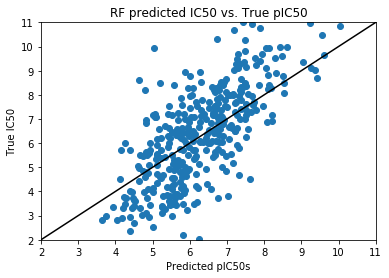

In [23]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

rf_predicted_test = best_rf.predict(test_dataset)
rf_true_test = test_dataset.y
plt.scatter(rf_predicted_test, rf_true_test)
plt.xlabel('Predicted pIC50s')
plt.ylabel('True IC50')
plt.title(r'RF predicted IC50 vs. True pIC50')
plt.xlim([2, 11])
plt.ylim([2, 11])
plt.plot([2, 11], [2, 11], color='k')
plt.show()

This model seems reasonably predictive! It's likely that this model is still a ways from being good enough to use in a production setting, but this isn't bad for a quick target discovery application

 